#### Import / Global Vars

In [66]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [67]:
#imports section
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import cvxpy as cvx
import re, os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from math import *
from datetime import datetime, date, time, timedelta
from time import sleep
from mvo_utils_v2 import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [68]:
# New L/S utility functions

# explicit function to review global vars
def print_global_vars():
    global_vars_fmt = "Global Variables\n" \
    "Refresh Pricing: {}\n" + "Historical Time Window: {}\n" + "Lookback: {}\n" \
    + "Rebalance Frequency: {}\n" + "Net Exposure: {}\n" \
    + "Leverage: {}\n" + "Weights: min {} to max {}\n" + "Universe: {}\n"
    print(global_vars_fmt.format(refresh_pricing, hist_window, lookback, rebal_frequency, net_exposure, leverage, min_weight, max_weight, universe))

# long-short version of recommend allocations
def ls_recommend_allocs(px, lb, net_exp, lev, min_w, max_w, gamma_val):
    px = clean_nas(px) # clean dataframe
    px_portion = px[-lb:] # subselect the period to optimize; frame and lb were duplicatives
    returns, alloc = ls_get_weights(
        px_portion, lb, net_exp, lev, min_w, max_w, gamma_val) # subselect the period to optimize
    port_perf = calc_port_performance(returns.values, alloc.values)
    pdf = pd.DataFrame(port_perf, index=returns.index, columns=["Quantum"])
    return px_portion, returns, alloc, pdf

# long-short version of optimization, position weights
def ls_get_weights(px, lb, min_sum, max_sum, min_w, max_w, gamma_val):
    lb_rets = px.sort_index().pct_change().fillna(0) # capture the last lb days going back
    n = lb_rets.shape[1]; mu = lb_rets.mean().values.T; Sigma = lb_rets.cov().values
    w = cvx.Variable(n)
    gamma = cvx.Parameter(sign='positive')
    Lmax = cvx.Parameter()
    ret = mu.T * w; risk = cvx.quad_form(w, Sigma)
    lo_obj = cvx.Maximize(ret - gamma*risk)
    ls_const = [cvx.sum_entries(w) == min_sum, cvx.norm(w, 1) < Lmax, w <= max_w, w >= min_w]
    prob = cvx.Problem(lo_obj, ls_const)
    gamma.value = gamma_val; Lmax.value = max_sum
    prob.solve()
    weights = w.value if prob.status == 'optimal' else np.zeros((n, 1))
    np_weights = np.array(weights)
    lb_weights = pd.DataFrame(np_weights.T, index=[lb_rets.index[-1]], columns=lb_rets.columns)
    return lb_rets, lb_weights

# pending implementation using partials
def quick_gamma(glist, px, lb, net_exp, lev, min_w, max_w):
    if len(glist) <= 1: 
        mid_g = glist[0]
        mid_sr = get_sr_for_opt(px, lb, net_exp, lev, min_w, max_w, mid_g)
        return mid_g, mid_sr
    else:
        mid = len(glist)//2; left = glist[:mid]; right = glist[mid:]
        mid_l = left[len(left)//2]; mid_r = right[len(right)//2]
        left_sr = get_sr_for_opt(px, lb, net_exp, lev, min_w, max_w, mid_l)
        right_sr = get_sr_for_opt(px, lb, net_exp, lev, min_w, max_w, mid_r)
        sublist = left if left_sr > right_sr else right
        #if left_sr > right_sr: sublist = left
        #else: sublist = right
        return quick_gamma(sublist, px, lb, net_exp, lev, min_w, max_w)

# return portfolio sharpe for a given optimization
def get_sr_for_opt(px, lb, net_exp, lev, min_w, max_w, gamma):
    px_p, _, alloc, pdf = ls_recommend_allocs(px, lb, net_exp, lev, min_w, max_w, gamma)
    rec = last_allocation(alloc, 0.01)
    ret, risk = port_metrics(px_p, rec)
    return ret / risk

# cleans small positions in long-short portfolios based on minimum weight criteria
def filter_ls(rec, pos_filter):
    long = rec[(rec > pos_filter).values]; short = rec[(rec < -pos_filter).values]
    return long.append(short)

#calculates the historical allocations based on a date frequency
def get_hist_allocs(rebal_freq, px, lb, g_samples, min_len, pos_filter):
    px = clean_nas(px)
    as_of_idx = px.head(1).combine_first(px.asfreq(rebal_freq)).dropna()
    hist_allocs = pd.DataFrame([], index=as_of_idx.index)
    if log: print(len(as_of_idx.index), "rebalances"); print(as_of_idx.index)
    for d in as_of_idx.index:
        subset = px.loc[:d]; days = len(subset)
        if days < min_len: continue
        gamma_val, gamma_sr = quick_gamma(gamma_vals, subset, lb, net_exposure, leverage, min_weight, max_weight)
        if log: print("rebalancing: {0}, {1:.2f}, {2:.2f}".format(d, gamma_val, gamma_sr))
        px_portion, returns, alloc, pdf = ls_recommend_allocs(
            subset, lb, net_exposure, leverage, min_weight, max_weight, gamma_val)
        rec = last_allocation(alloc, min_weight)
        l_s = filter_ls(rec, pos_filter)
        hist_allocs = hist_allocs.combine_first(alloc[l_s.index])
    return hist_allocs

# alings allocations with trading days
def align_ret_allocs(allocs, px):
    rets = px[allocs.columns].pct_change().fillna(0)
    resampled_alloc = allocs.resample('D').pad()
    resampled_alloc = resampled_alloc.loc[rets.index]
    return rets, resampled_alloc

# summary plots
def plot_bt_summary(df):
    pct_chg_df = df.pct_change()
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,3), dpi=300)
    compound(df).plot(ax=ax1, x_compat=True)
    ax1.yaxis.set_label('Indexed Return')
    pct_chg_df.plot.hist(ax=ax2, stacked=True, bins=20)
    pct_chg_df.boxplot(ax=ax3)
    pct_chg_df.plot.kde(ax=ax4)
    print(pct_chg_df.describe().applymap(short_float))
    
# create portfolio risk metric matrix for net exposure selection
TS_METRICS_LEGEND = ['Return', 'Risk', 'RSpread', 'Sharpe', 'MaxDraw']
port_risk_matrix = lambda x: pd.Series([x for x in ts_metrics(x)], index=TS_METRICS_LEGEND)
def ts_metrics(pdf):
    timespan = len(pdf.index)
    ret = (pdf.pct_change().mean() * timespan)
    std = (pdf.pct_change().std() * sqrt(timespan))
    mdd = max_drawdown(pdf)[0];
    
    return ret, std, ret - std, ret / std, mdd

# calculates max drawdown, largest reduction from highest point
def max_drawdown(xs):
    i = np.argmax(np.maximum.accumulate(xs) - xs) # end of the period
    j = np.argmax(xs[:i]) # start of period
    pct_mdd = -1 * ((xs[j] - xs[i]) / xs[j])
    return pct_mdd, j, i

# plots max drawdown chart
def plot_max_drawdown(xs):
    _, j, i = max_drawdown(xs)
    plt.plot(xs)
    plt.legend()
    plt.plot([i, j], [xs[i], xs[j]], 'o', color='Red', markersize=5)

In [69]:
# Global variables
log = True
refresh_pricing = False
universe = 'spy-sectors'  # 'spy_sectors OR 'ark_etfs'
active_etf = None  # ETF name OR None for broad market

#variables for performance analysis
lookback = 60
net_exposure = 0
leverage = 1
min_weight = -0.05
max_weight = 0.05  # default optimization vars
min_len = 3
pos_filter = 0.01  # cleaning variables
rebal_frequency = 'W-' + datetime.now().strftime('%a')  # for historical allocations
gamma_vals = np.logspace(0, 2.3, num=10)  # 1 to 1000 range

net_exposures = np.arange(0.0, 1.01, 0.1)
left_substr = lambda a, i: [str(c)[:i] for c in a.columns.tolist()]
BACKTEST_PATH = './backtests/'
RECOMMENDATION_PATH = './recommendations/'
FNAME_INDEX = "{}backtest-{}-{}.csv"
FNAME_GEN = "{}{}-{}-{}-{}.csv"

print_global_vars()

Global Variables
Refresh Pricing: False
Historical Time Window: 100
Lookback: 60
Rebalance Frequency: W-Wed
Net Exposure: 0
Leverage: 1
Weights: min -0.05 to max 0.05
Universe: spy-sectors



#### Load sector components from hard-drive

In [70]:
# load spy sector components
# would be nice to load a JSON with configuration
ticker_map = {
    'benchmark': ['SPY'],
    'equity': ['VTI','VTV','VOE','VBR','VEA','VWO'],
    'fixed_income': ['VTIP', 'SHV', 'MUB', 'LQD', 'BNDX', 'EMB'],
    'spy-sectors': ['XLE', 'XLU', 'XLK', 'XLB', 'XLP', 'XLY', 'XLI', 'XLV', 'XLF', 'XLRE'],
    'ark-etfs': ['ARKG', 'ARKK', 'ARKQ', 'ARKW']
}

config = {
    'spy-sectors' : {
        'hold_cols': ['Symbol','Company Name', 'Index Weight'],
        'hold_format': r'holdings-spy-',
        'idx_col': 'Symbol',
        'fname': 'spy-sectors',
        'skiprows': 1
    },
    'ark-etfs' : {
        'hold_cols': ['ticker','company', 'weight(%)'],
        'hold_format': r'holdings-ark-',
        'idx_col': 'ticker',
        'fname': 'ark-etfs',
        'skiprows': 0
    }
}

hold_cols = config[universe]['hold_cols']
hold_format = config[universe]['hold_format']
idx_col = config[universe]['idx_col']
fname = config[universe]['fname']
skiprows = config[universe]['skiprows']

companies = load_components(
    companies, hold_format, hold_cols, 
    idx_col, ticker_map[universe], srows=skiprows)
print("Companies loaded:", companies.shape)
px_etfs = load_pricing(fname + '.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')

Companies loaded: (505, 3)
Loaded pricing for spy-sectors.csv, with shape (69, 10)
Loaded pricing for SPY.csv, with shape (69, 1)


#### Get Data from the Server

In [72]:
# New approach using dynamic key lookup name
if refresh_pricing:
    etfs = [e for e in ticker_map[universe]]
    refresh_components(etfs)
    get_safe_pricing(universe + '.csv', ticker_map[universe], start_date)
    get_safe_pricing('SPY.csv', ['SPY'], start_date)

In [73]:
# Load pricing for components of each sectors
px_etfs = load_pricing(universe + '.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')
consol_px = clean_nas(load_consol_px(ticker_map, universe))
if(active_etf != None): companies = companies[companies['ETF']==active_etf] # filter by selected ETF
tickers = companies.index.tolist()
tickers=[i for i in tickers if i not in ['BF.b','BRK.b']] ## esta es una correcion extra para no incluir 'BF.b','BRK.b'
consol_px = consol_px[list(set(tickers))]

Loaded pricing for spy-sectors.csv, with shape (69, 10)
Loaded pricing for SPY.csv, with shape (69, 1)
Loaded pricing for XLE-hold-pricing.csv, with shape (2605, 31)
Loaded pricing for XLU-hold-pricing.csv, with shape (2605, 28)
Loaded pricing for XLK-hold-pricing.csv, with shape (2605, 73)
Loaded pricing for XLB-hold-pricing.csv, with shape (2605, 25)
Loaded pricing for XLP-hold-pricing.csv, with shape (2605, 34)
Loaded pricing for XLY-hold-pricing.csv, with shape (2605, 82)
Loaded pricing for XLI-hold-pricing.csv, with shape (2605, 70)
Loaded pricing for XLV-hold-pricing.csv, with shape (2605, 61)
Loaded pricing for XLF-hold-pricing.csv, with shape (2605, 68)
Loaded pricing for XLRE-hold-pricing.csv, with shape (2605, 33)


#### Generate Trading Recomendations

In [74]:
# Removing tickers for M&A targets and diff class shares of same co.
remove_tickers = ['CSRA', 'DPS', 'UAA', 'DISCK', 'JUNO', 'XL', 'WELL', 'BKNG', 'SNI','EVGN', 'CBRE']
remove = list(set(remove_tickers).intersection(consol_px.columns.tolist()))
if len(remove) > 0: consol_px.drop(remove, axis=1, inplace=True)
consol_px.shape
consol_px = consol_px[sorted(consol_px.columns.tolist())]
consol_px.to_csv("consol_algo.csv") # what is this line for? missing date, how does it connect to recommendations?
consol_px.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2605 entries, 2007-11-16 to 2018-03-23
Columns: 495 entries, A to ZTS
dtypes: float64(495)
memory usage: 9.9 MB


In [75]:
# Runs portfolios for all net exposures to determine best choice
log = True
time_frame = -60; rebal_frequency = 'W-WED'
subset = consol_px[time_frame:]
net_exp_port = pd.DataFrame([])

for ne in net_exposures:
    net_exposure = ne
    hist_allocs = get_hist_allocs(rebal_frequency, subset, lookback, gamma_vals, min_len, pos_filter)
    returns, allocs = align_ret_allocs(hist_allocs, subset)
    time_series = calc_port_performance(returns, allocs).to_frame()
    time_series.columns = [ne]
    net_exp_port = net_exp_port.combine_first(time_series.copy())
net_exp_port.columns = left_substr(net_exp_port, 3)

13 rebalances
DatetimeIndex(['2017-12-27', '2018-01-03', '2018-01-10', '2018-01-17',
               '2018-01-24', '2018-01-31', '2018-02-07', '2018-02-14',
               '2018-02-21', '2018-02-28', '2018-03-07', '2018-03-14',
               '2018-03-21'],
              dtype='datetime64[ns]', name='Date', freq=None)
rebalancing: 2018-01-03 00:00:00, 199.53, 3.67
rebalancing: 2018-01-10 00:00:00, 110.78, 5.69
rebalancing: 2018-01-17 00:00:00, 34.15, 4.62
rebalancing: 2018-01-24 00:00:00, 110.78, 5.48


/Users/vicveiga/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


rebalancing: 2018-01-31 00:00:00, 61.50, 5.26
rebalancing: 2018-02-07 00:00:00, 61.50, 2.84
rebalancing: 2018-02-14 00:00:00, 34.15, 2.46
rebalancing: 2018-02-21 00:00:00, 18.96, 2.73
rebalancing: 2018-02-28 00:00:00, 10.53, 2.60
rebalancing: 2018-03-07 00:00:00, 199.53, nan
rebalancing: 2018-03-14 00:00:00, 18.96, 3.25
rebalancing: 2018-03-21 00:00:00, 34.15, 3.21


/Users/vicveiga/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


13 rebalances
DatetimeIndex(['2017-12-27', '2018-01-03', '2018-01-10', '2018-01-17',
               '2018-01-24', '2018-01-31', '2018-02-07', '2018-02-14',
               '2018-02-21', '2018-02-28', '2018-03-07', '2018-03-14',
               '2018-03-21'],
              dtype='datetime64[ns]', name='Date', freq=None)
rebalancing: 2018-01-03 00:00:00, 199.53, 3.61
rebalancing: 2018-01-10 00:00:00, 110.78, 5.68
rebalancing: 2018-01-17 00:00:00, 34.15, 4.65
rebalancing: 2018-01-24 00:00:00, 61.50, 5.47
rebalancing: 2018-01-31 00:00:00, 18.96, 5.39
rebalancing: 2018-02-07 00:00:00, 34.15, 2.84
rebalancing: 2018-02-14 00:00:00, 199.53, nan
rebalancing: 2018-02-21 00:00:00, 61.50, 2.77
rebalancing: 2018-02-28 00:00:00, 34.15, 2.61
rebalancing: 2018-03-07 00:00:00, 61.50, 3.27
rebalancing: 2018-03-14 00:00:00, 61.50, 3.32
rebalancing: 2018-03-21 00:00:00, 61.50, 3.33
13 rebalances
DatetimeIndex(['2017-12-27', '2018-01-03', '2018-01-10', '2018-01-17',
               '2018-01-24', '2018-01-31',

rebalancing: 2018-01-03 00:00:00, 199.53, 41.58
rebalancing: 2018-01-10 00:00:00, 199.53, 15.33
rebalancing: 2018-01-17 00:00:00, 199.53, 11.45
rebalancing: 2018-01-24 00:00:00, 199.53, 13.35
rebalancing: 2018-01-31 00:00:00, 199.53, 10.70
rebalancing: 2018-02-07 00:00:00, 34.15, 3.14
rebalancing: 2018-02-14 00:00:00, 34.15, 2.72
rebalancing: 2018-02-21 00:00:00, 10.53, 2.79
rebalancing: 2018-02-28 00:00:00, 10.53, 2.66
rebalancing: 2018-03-07 00:00:00, 10.53, 3.15
rebalancing: 2018-03-14 00:00:00, 10.53, 3.22
rebalancing: 2018-03-21 00:00:00, 10.53, 3.15


In [77]:
# creates portfolio risk metric matrix to determine best net exposure
# select the best net exposure (highest sharpe and lowest drawdown), recreates weekly balancing
risk_matrix = net_exp_port.apply(port_risk_matrix)
net_exposure = float(risk_matrix.loc['Sharpe'].argmax())
risk_matrix

/Users/vicveiga/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/Users/vicveiga/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  after removing the cwd from sys.path.


,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
Return,0.123427,0.115774,0.114540,0.116094,0.130974,0.139718,0.110341,0.091052,0.094991,0.095542,0.087358
Risk,0.039658,0.039651,0.041062,0.047365,0.051088,0.049021,0.063377,0.064718,0.072482,0.077683,0.088564
RSpread,0.083769,0.076123,0.073478,0.068729,0.079886,0.090697,0.046964,0.026334,0.022509,0.017859,-0.001206
Sharpe,3.112292,2.919831,2.789450,2.451063,2.563682,2.850147,1.741026,1.406904,1.310544,1.229892,0.986388
MaxDraw,-0.015819,-0.021705,-0.028314,-0.031745,-0.030882,-0.026025,-0.053432,-0.060802,-0.070573,-0.079737,-0.089879


In [78]:
# calculates optimal gamma
gamma_val, gamma_sr = quick_gamma(
    gamma_vals, consol_px, lookback, net_exposure, leverage, min_weight, max_weight)
gamma_val, gamma_sr

(34.145488738336006, 2.564945531779756)

In [79]:
# run portfolio with best net exposure
px_portion, returns, alloc, pdf = ls_recommend_allocs(
    consol_px, lookback, net_exposure, leverage, min_weight, max_weight, gamma_val)
rec = last_allocation(alloc, min_weight)
recommend = filter_ls(rec, pos_filter)
tickers = recommend.index.tolist()

In [80]:
cos_no_dup = companies.drop_duplicates(subset='Company')
recommend['Sector'] = cos_no_dup.loc[tickers]['ETF']
recommend['Company'] = cos_no_dup.loc[tickers][['Company']]
recommend = recommend.astype({"Allocation": np.float})
recommend[['Company', 'Sector', 'Allocation']]

print("{} Positions, {} Long, {} Short, Long Exposure: {}, Short Exposure {}".format(
    len(recommend.index), 
    len(recommend[recommend['Allocation'] > 0]), 
    len(recommend[recommend['Allocation'] < 0 ]),
    recommend[recommend['Allocation'] > 0]['Allocation'].sum(),
    recommend[recommend['Allocation'] < 0]['Allocation'].sum()))
recommend

25 Positions, 11 Long, 14 Short, Long Exposure: 0.47627803424616133, Short Exposure -0.47982574642434694


,Allocation,Sector,Company
AMZN,0.050000,XLY,Amazon.com Inc
APC,0.050000,XLE,Anadarko Petroleum Corp
EW,0.017081,XLV,Edwards Lifesciences Corp
GWW,0.023777,XLI,Grainger W.W. Inc
IDXX,0.050000,XLV,IDEXX Laboratories Inc
MU,0.050000,XLK,Micron Technology Inc
NFLX,0.050000,XLY,NetFlix Inc
NKTR,0.050000,XLV,Nektar Therapeutics
RHT,0.050000,XLK,Red Hat Inc
STX,0.050000,XLK,Seagate Technology


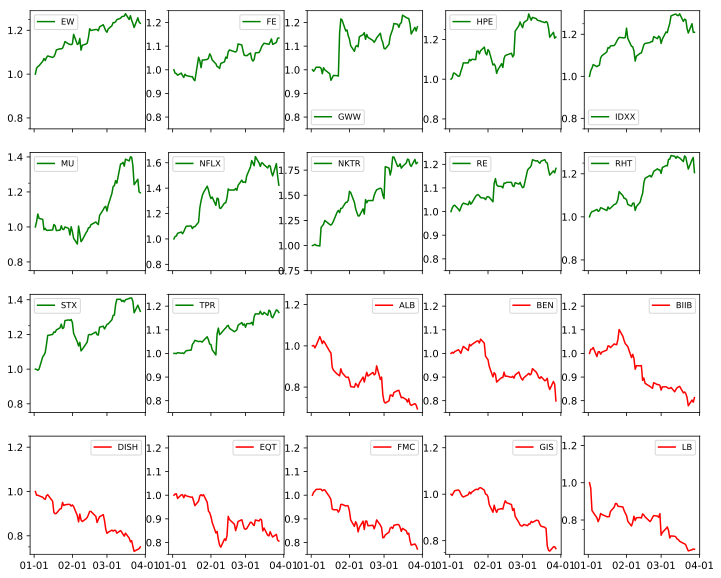

In [129]:
# plots all tickers to verify if there are any M&A targets
nbr_charts = len(sorted(tickers)); cols = 5
fig, ax = plt.subplots(nbr_charts // cols, cols, figsize=(12,10), sharex=True)
# fig -> set fig spacing and general properties
for i, axi in enumerate(ax.flat):
    co = tickers[i]
    df_range = compound(consol_px[co][-lookback:])
    weight = recommend.loc[co]['Allocation']
    color = '-g' if weight > 0 else '-r'
    axi.plot(df_range.index.to_datetime().tolist(), df_range.values, color, label=df_range.name)
    axi.legend(fontsize='small')
    axi.xaxis.set_major_locator(mdates.MonthLocator())
    axi.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    axi.yaxis.set_ticks([0.75, 1.25], minor=True)

In [130]:
sect_group_stats(recommend, 'Sector').sort_values(by='Sector Weight', ascending=False)

Total % Allocation 0.28


,Sector Weight,Avg Position
XLK,1.518115e-01,3.795289e-02
XLI,4.956290e-02,4.956290e-02
XLV,4.372515e-02,8.745030e-03
XLU,2.940389e-02,2.940389e-02
XLF,-8.283992e-12,-4.141996e-12
XLY,-3.071569e-02,-7.678921e-03
XLP,-5.000000e-02,-5.000000e-02
XLB,-7.928612e-02,-3.964306e-02
XLE,-1.117439e-01,-3.724797e-02


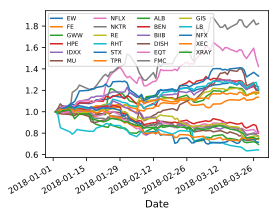

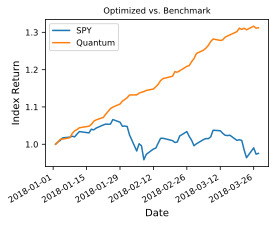

In [131]:
port_pos_idx = compound(consol_px[-lookback:][recommend.index])
ax = port_pos_idx.plot(fontsize='small', figsize=(4,3))
ax.legend(fontsize='xx-small', ncol=4)
idx_px_spy = compound(px_spy.loc[port_pos_idx.index])
plot_two_series(idx_px_spy, pdf, 'SPY', 'Quantum', 'Date', 'Index Return', 'Optimized vs. Benchmark')

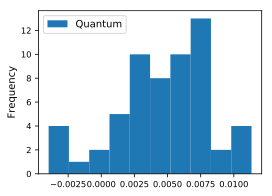

In [132]:
pdf.pct_change().plot(kind='hist', figsize=(4,3), fontsize='small')

In [133]:
# Outputs for trade execution
px = consol_px[tickers][-lookback:]
date = px[-1:].index.to_datetime().strftime(date_fmt)[0]
ret, risk = port_metrics(px_portion, rec)

trading_cols = ['Company', 'Price', 'Allocation', 'Dollar Value', 'Shares']
trading_df = pd.DataFrame([], index=recommend.index, columns=trading_cols)

round_shares = lambda x: round(x, 0)
port_bal = 220000; alloc = recommend['Allocation']
pvalue = (port_bal * alloc)
shares = (port_bal * alloc) / px[-1:]
shares.apply(round_shares).T.sort_index()

trading_df['Company'] = recommend['Company']
trading_df['Price'] = px[-1:].T
trading_df['Allocation'] = recommend['Allocation']
trading_df['Dollar Value'] = trading_df['Allocation'] * port_bal
trading_df['Shares'] = trading_df['Dollar Value'] / trading_df['Price']

print_global_vars()
print("Ann. Ret: {0:.2f}, Risk: {1:.2f} Sharpe: {2:.2f}".format(ret, risk, ret / risk))
print("{} Positions, {} Long, {} Short, Long Exposure: {}, Short Exposure {}".format(
    len(recommend.index), 
    len(recommend[recommend['Allocation'] > 0]), 
    len(recommend[recommend['Allocation'] < 0 ]),
    recommend[recommend['Allocation'] > 0]['Allocation'].sum(),
    recommend[recommend['Allocation'] < 0]['Allocation'].sum())
     )

print("Date: {0}, Net Dollar Exposure: {1:.2f}, Total Allocation: {2:.2f}%".format(date, trading_df['Dollar Value'].sum(), trading_df['Allocation'].sum() * 100))
trading_df.head()
trading_df = trading_df.astype({'Dollar Value':np.int, 'Shares':np.int})

if refresh_pricing:
    HISTREC_PATH = "./recommendations/"
    pre_name = HISTREC_PATH + "portrec_" + universe + '_'
    fname = datetime.now().strftime(pre_name + date_fmt + r'_%H-%M') + '.csv'
    trading_df.to_csv(fname)
    print('Saved portfolio rebalance:', fname)
trading_df.sort_index()

Global Variables
Refresh Pricing: False
Historical Time Window: 100
Lookback: 60
Rebalance Frequency: W-WED
Net Exposure: 0.0
Leverage: 1
Weights: min -0.05 to max 0.05
Universe: spy-sectors

Ann. Ret: 0.27, Risk: 0.03 Sharpe: 10.27
23 Positions, 12 Long, 11 Short, Long Exposure: 0.4937877963039947, Short Exposure -0.4910300229657238
Date: 2018-03-28, Net Dollar Exposure: 606.71, Total Allocation: 0.28%


,Company,Price,Allocation,Dollar Value,Shares
ALB,Albemarle Corp,91.010002,-0.041020,-9024,-99
BEN,Franklin Resources Inc,34.340000,-0.050000,-10999,-320
BIIB,Biogen Inc,271.670013,-0.050000,-10999,-40
DISH,DISH Network Corp A,37.639999,-0.050000,-10999,-292
EQT,EQT Corporation,47.220001,-0.011744,-2583,-54
EW,Edwards Lifesciences Corp,137.479996,0.050000,10999,80
FE,FirstEnergy Corp,34.576599,0.029404,6468,187
FMC,FMC Corp,73.769997,-0.038266,-8418,-114
GIS,General Mills Inc,44.845001,-0.050000,-10999,-245
GWW,Grainger W.W. Inc,277.149994,0.049563,10903,39
